In [1]:
%load_ext autoreload
%autoreload 2

import pymdp
from pymdp.jax.envs.generalized_tmaze import GeneralizedTMaze, GeneralizedTMazeEnv

import numpy as np 
import jax.random as jr 
import jax.numpy as jnp

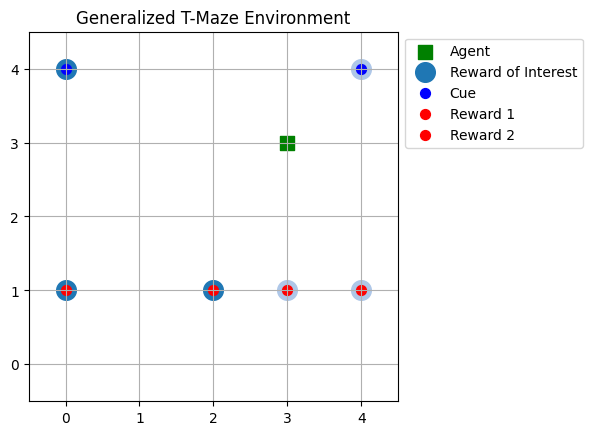

In [2]:
M = np.zeros((5, 5))
M[1,0] = 4
M[1,2] = 5
M[1,3] = 7

M[1,4] = 8
M[4,0] = 3
M[4,4] = 6

M[3,3] = 1
env = GeneralizedTMaze(M)
tmaze_env = GeneralizedTMazeEnv(M)

_ = env.render_env(tmaze_env)

In [3]:
import jax.tree_util as jtu 

jtu.tree_map(lambda x: print(x.shape), tmaze_env.params)

(1, 25, 25)
(1, 3, 25, 2)
(1, 3, 25, 2)
(1, 3, 25, 2)
(1, 3, 25, 2)
(1, 25, 25, 4)
(1, 2, 2, 1)
(1, 2, 2, 1)
(1, 25)
(1, 2)
(1, 2)


{'A': [None, None, None, None, None],
 'B': [None, None, None],
 'D': [None, None, None]}

In [4]:
batch_size = 1
seed = 0 
key = jr.PRNGKey(seed)

key, *subkeys = jr.split(key, batch_size + 1)
subkeys = jnp.array(subkeys)

tmaze_env.step(subkeys)

([Array([18], dtype=int32),
  Array([0], dtype=int32),
  Array([0], dtype=int32),
  Array([0], dtype=int32),
  Array([0], dtype=int32)],
 GeneralizedTMazeEnv(
   params={
     'A':
     [f32[1,25,25], f32[1,3,25,2], f32[1,3,25,2], f32[1,3,25,2], f32[1,3,25,2]],
     'B':
     [f32[1,25,25,4], f32[1,2,2,1], f32[1,2,2,1]],
     'D':
     [f32[1,25], f32[1,2], f32[1,2]]
   },
   state=[i32[1], i32[1], i32[1]],
   dependencies={
     'A':
     [[0], [0, 1], [0, 2], [0, 1], [0, 2]],
     'B':
     [[0], [1], [2]]
   }
 ))

In [5]:
from pymdp.jax.agent import Agent

A = [a.copy() for a in tmaze_env.params["A"]]
B = [b.copy() for b in tmaze_env.params["B"]]
A_dependencies = tmaze_env.dependencies["A"]
B_dependencies = tmaze_env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) for b in B]

agent = Agent(
    A, B, C, D, 
    None, None, None, 
    policy_len=5,
    A_dependencies=A_dependencies, 
    B_dependencies=B_dependencies
)

In [6]:
obs, _ = tmaze_env.step(subkeys)

qs = [jnp.broadcast_to(d, (1,) + d.shape) for d in D]

qpi, nefe = agent.infer_policies(qs)

In [7]:
batch_size = 1
key, *subkeys = jr.split(key, batch_size + 1)
actions = agent.sample_action(qpi, rng_key=jnp.array(subkeys))


key, *subkeys = jr.split(key, batch_size + 1)
obs, _ = tmaze_env.step(jnp.array(subkeys), actions)

In [8]:
obs_b = [jnp.broadcast_to(o, (1,) + o.shape) for o in obs]
prior, _ = agent.update_empirical_prior(actions, qs)
res = agent.infer_states(obs_b, None, prior, None)

In [9]:
tmaze_env.params['A'][2].shape

(1, 3, 25, 2)

In [10]:
from pymdp.jax.envs.rollout import rollout

_, info, _ = rollout(agent, tmaze_env, num_timesteps=20, batch_size=1, rng_key=key)

[Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=1/0)>, Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=1/0)>]
__


(20, 1, 1)
(1, 2, 25)


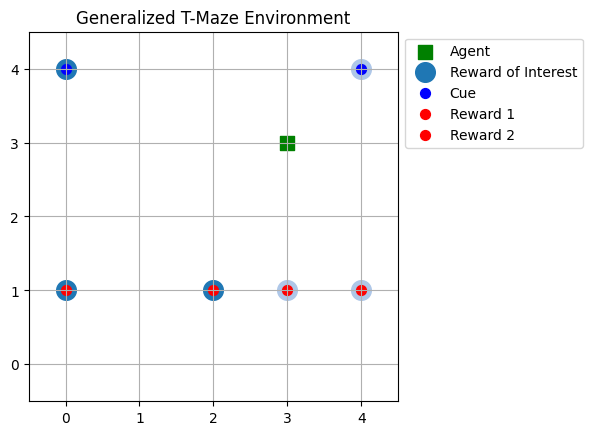

0
0
--
(20, 1, 1)
(1, 2, 25)


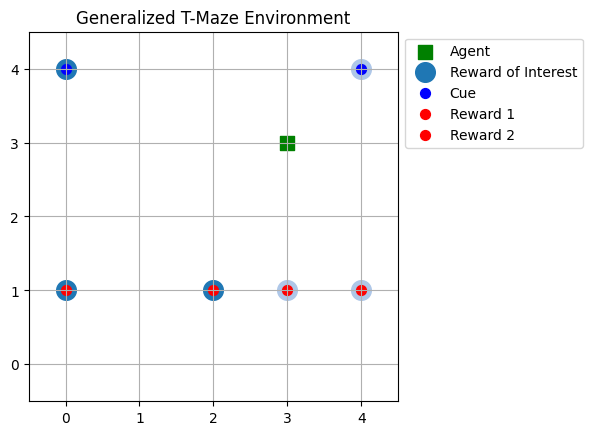

0
0
--
(20, 1, 1)
(1, 2, 25)


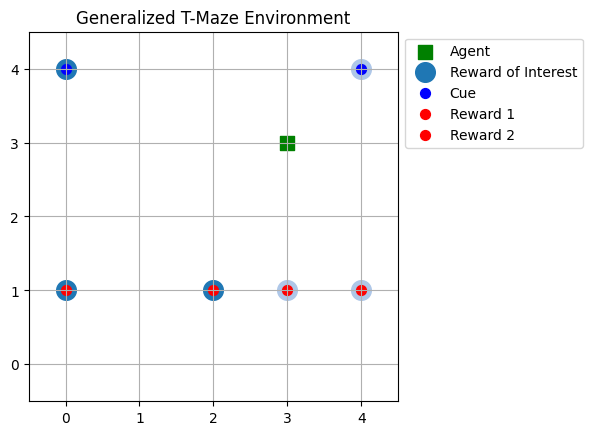

0
0
--
(20, 1, 1)
(1, 2, 25)


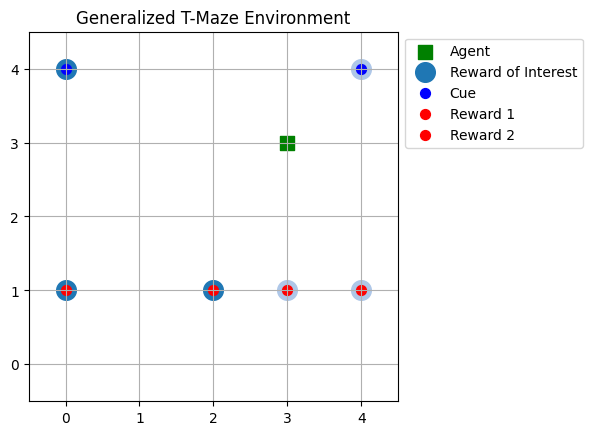

0
0
--
(20, 1, 1)
(1, 2, 25)


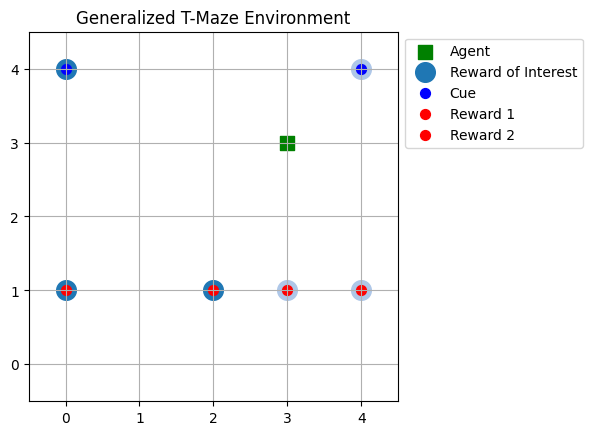

0
0
--


IndexError: list index out of range

In [13]:
for t in range(20): 
    obs = info['observation']
    print(obs.shape)
    #env_state = jtu.tree_map(lambda x: print(x.shape), info['env'])
    print(info['qs'][0][t].shape)
    env_state = jtu.tree_map(lambda x: x[t], info['env'])
    env.render_env(env_state)

    print(info['qs'][0][t][0].argmax())
    print(info['qs'][0][t][1].argmax())
    print("--")